#  $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$  Course 9 - Applied Data Science Capstone
#  $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$  Stefanos Nikolas Yiallouros
#  $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$  Week 5.1 
# $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ Capstone Project
# $\;\;\;\;$The Battle of Neighborhoods – Finding a Better Place in Scarborough, Toronto 

### 1. Installing and Importing Python Libraries and Dependencies 

In [2]:
!pip install geocoder
!pip install folium

     |████████████████████████████████| 102kB 6.8MB/s ta 0:00:011
     |████████████████████████████████| 102kB 6.5MB/s ta 0:00:011


### Importing Libraries

In [3]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


### 2. Data Extraction and Cleaning
Using BeautifulSoup Scraping List of Postal Codes of Given Wikipedia Page. Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [4]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

### Converting content of PostalCode HTML table as dataframe



In [5]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [11]:
# clean dataframe 
toronto = toronto[toronto.Borough!='Not assigned\n']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned\n':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [12]:
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1B\n,Scarborough\n,"Malvern, Rouge"
1,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
2,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
3,M1G\n,Scarborough\n,Woburn
4,M1H\n,Scarborough\n,Cedarbrae


In [13]:
df.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,10,98
top,M9N\n,North York\n,Downsview
freq,1,24,4


In [14]:
df = df.dropna()
empty = 'Not assigned\n'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [15]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1B\n,Scarborough\n,"Malvern, Rouge"
1,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
2,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
3,M1G\n,Scarborough\n,Woburn
4,M1H\n,Scarborough\n,Cedarbrae


In [16]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [17]:
df_2.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,10,98
top,M9N\n,North York\n,Downsview
freq,1,24,4


In [18]:
print(df_2.shape)
df_2.head()

(103, 3)


,Postalcode,Borough,Neighborhood
0,M1B\n,Scarborough\n,"Malvern, Rouge"
1,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
2,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
3,M1G\n,Scarborough\n,Woburn
4,M1H\n,Scarborough\n,Cedarbrae


In [25]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.70941386000004, -79.36309957799995]

In [20]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [21]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [27]:
df_2[df_2.Postalcode == 'M5G']
df_2.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B\n,Scarborough\n,"Malvern, Rouge",43.808626,-79.189913
1,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek",43.785779,-79.157368
2,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill",43.765806,-79.185284
3,M1G\n,Scarborough\n,Woburn,43.771545,-79.218135
4,M1H\n,Scarborough\n,Cedarbrae,43.768791,-79.238813
5,M1J\n,Scarborough\n,Scarborough Village,43.744203,-79.228725
6,M1K\n,Scarborough\n,"Kennedy Park, Ionview, East Birchmount Park",43.726881,-79.265694
7,M1L\n,Scarborough\n,"Golden Mile, Clairlea, Oakridge",43.713340,-79.284942
8,M1M\n,Scarborough\n,"Cliffside, Cliffcrest, Scarborough Village West",43.723538,-79.228353
9,M1N\n,Scarborough\n,"Birch Cliff, Cliffside West",43.696448,-79.265642


In [28]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Seattle,Washington are 43.773077, -79.257774.


### 3. Map of Scarborough

In [29]:

map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [30]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.773077, -79.257774.


In [31]:
# @hiddel_cell
CLIENT_ID = 'DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY' # my Foursquare ID
CLIENT_SECRET = '1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY
CLIENT_SECRET: 1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B


In [33]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [34]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.id', 'venue.location.address', 'venue.location.cc',
       'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [35]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### 4. Nearby Venues/Locations

In [36]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
1,St. Andrews Fish & Chips,"[{'id': '4edd64a0c7ddd24ca188df1a', 'name': 'F...",43.771865,-79.252645
2,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
3,DAVIDsTEA,"[{'id': '4bf58dd8d48988d1dc931735', 'name': 'T...",43.776320,-79.258688
4,American Eagle Outfitters,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334


### 5. Categories of Nearby Venues/Locations

In [37]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Disney Store,Toy / Game Store,43.775537,-79.256833
1,St. Andrews Fish & Chips,Fish & Chips Shop,43.771865,-79.252645
2,SEPHORA,Cosmetics Shop,43.775017,-79.258109
3,DAVIDsTEA,Tea Room,43.776320,-79.258688
4,American Eagle Outfitters,Clothing Store,43.776012,-79.258334


In [38]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store      8
Coffee Shop         4
Restaurant          4
Sandwich Place      2
Pharmacy            2
Cosmetics Shop      2
Tea Room            2
Gas Station         2
Department Store    1
Shoe Store          1
Name: categories, dtype: int64

In [40]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [41]:

# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale
York Mills West
Willowdale
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence P

In [42]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 312 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,31,31,31,31,31,31
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Wilson Heights, Downsview North",23,23,23,23,23,23
Bayview Village,5,5,5,5,5,5
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24


### One Hot Encoding of Features

In [43]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Yoga Studio,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Quad,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Paintball Field,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Supermarket,

In [44]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                venue  freq
0       Shopping Mall  0.06
1  Chinese Restaurant  0.06
2                Café  0.03
3    Sushi Restaurant  0.03
4         Supermarket  0.03


---- Alderwood, Long Branch ----
            venue  freq
0            Pool   0.1
1    Dance Studio   0.1
2  Sandwich Place   0.1
3     Gas Station   0.1
4             Gym   0.1


---- Bathurst Manor, Wilson Heights, Downsview North ----
         venue  freq
0         Park  0.09
1  Coffee Shop  0.09
2         Bank  0.09
3  Gas Station  0.04
4  Men's Store  0.04


---- Bayview Village ----
                        venue  freq
0                        Park   0.6
1  Construction & Landscaping   0.2
2                       Trail   0.2
3                 Yoga Studio   0.0
4                 Music Store   0.0


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0          Restaurant  0.08
1      Sandwich Place  0.08
2         Coffee Shop  0.08
3  Italian Restaurant  0.08
4           Juice

         venue  freq
0   Playground  0.25
1         Park  0.25
2         Café  0.25
3  Coffee Shop  0.25
4  Yoga Studio  0.00


---- Humewood-Cedarvale ----
               venue  freq
0      Grocery Store  0.22
1  Convenience Store  0.11
2     Soccer Stadium  0.11
3       Hockey Arena  0.11
4              Field  0.11


---- India Bazaar, The Beaches West ----
                  venue  freq
0        Sandwich Place  0.06
1  Fast Food Restaurant  0.06
2           Coffee Shop  0.04
3            Restaurant  0.04
4               Brewery  0.04


---- Islington Avenue ----
           venue  freq
0       Pharmacy  0.25
1   Skating Rink  0.12
2           Bank  0.12
3  Grocery Store  0.12
4  Shopping Mall  0.12


---- Kennedy Park, Ionview, East Birchmount Park ----
              venue  freq
0       Coffee Shop  0.13
1    Discount Store  0.13
2     Train Station  0.07
3  Department Store  0.07
4    Sandwich Place  0.07


---- Kensington Market, Chinatown, Grange Park ----
                         

         venue  freq
0          Pub  0.22
1  Coffee Shop  0.22
2    Gastropub  0.11
3  Cheese Shop  0.11
4       Bakery  0.11


---- The Danforth West, Riverdale ----
              venue  freq
0  Greek Restaurant  0.18
1              Café  0.09
2    Ice Cream Shop  0.06
3              Bank  0.06
4       Yoga Studio  0.03


---- The Kingsway, Montgomery Road, Old Mill North ----
                venue  freq
0    Sushi Restaurant  0.07
1      Breakfast Spot  0.07
2  Italian Restaurant  0.07
3                Bank  0.07
4              Bakery  0.07


---- Thorncliffe Park ----
               venue  freq
0  Indian Restaurant  0.09
1     Sandwich Place  0.09
2      Grocery Store  0.09
3               Park  0.09
4        Yoga Studio  0.05


---- Toronto Dominion Centre, Design Exchange ----
                 venue  freq
0          Coffee Shop  0.08
1                Hotel  0.07
2                 Café  0.07
3  Japanese Restaurant  0.04
4  American Restaurant  0.04


---- University of Toronto, Har

In [45]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Most Common venues near neighborhood

In [46]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Chinese Restaurant,Bubble Tea Shop,Mediterranean Restaurant,Latin American Restaurant,Breakfast Spot,Filipino Restaurant,Lounge,Malay Restaurant,Skating Rink
1,"Alderwood, Long Branch",Pizza Place,Pharmacy,Dance Studio,Sandwich Place,Skating Rink,Gym,Coffee Shop,Pub,Pool,Gas Station
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Park,Bank,Pharmacy,Bridal Shop,Middle Eastern Restaurant,Shopping Mall,Sandwich Place,Fried Chicken Joint,Sushi Restaurant
3,Bayview Village,Park,Construction & Landscaping,Trail,Women's Store,Electronics Store,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
4,"Bedford Park, Lawrence Manor East",Restaurant,Sandwich Place,Italian Restaurant,Coffee Shop,Indian Restaurant,Pharmacy,Butcher,Café,Liquor Store,Sports Club


### K-Means Clustering Approach

In [47]:
# Using K-Means to cluster neighborhood into 3 clusters
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1], dtype=int32)

In [48]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B\n,Scarborough\n,"Malvern, Rouge",43.808626,-79.189913,0,Trail,Park,Women's Store,Distribution Center,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
1,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek",43.785779,-79.157368,0,Bar,Construction & Landscaping,Park,Women's Store,Ethiopian Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
2,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill",43.765806,-79.185284,1,Pizza Place,Park,Fast Food Restaurant,Bank,Coffee Shop,Breakfast Spot,Discount Store,Mexican Restaurant,Sports Bar,Restaurant
3,M1G\n,Scarborough\n,Woburn,43.771545,-79.218135,1,Coffee Shop,Park,Business Service,Women's Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
4,M1H\n,Scarborough\n,Cedarbrae,43.768791,-79.238813,1,Thai Restaurant,Bank,Gas Station,Athletics & Sports,Hakka Restaurant,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant


### Map of Clusters

In [49]:
kclusters = 10

In [50]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [52]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [53]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

In [54]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

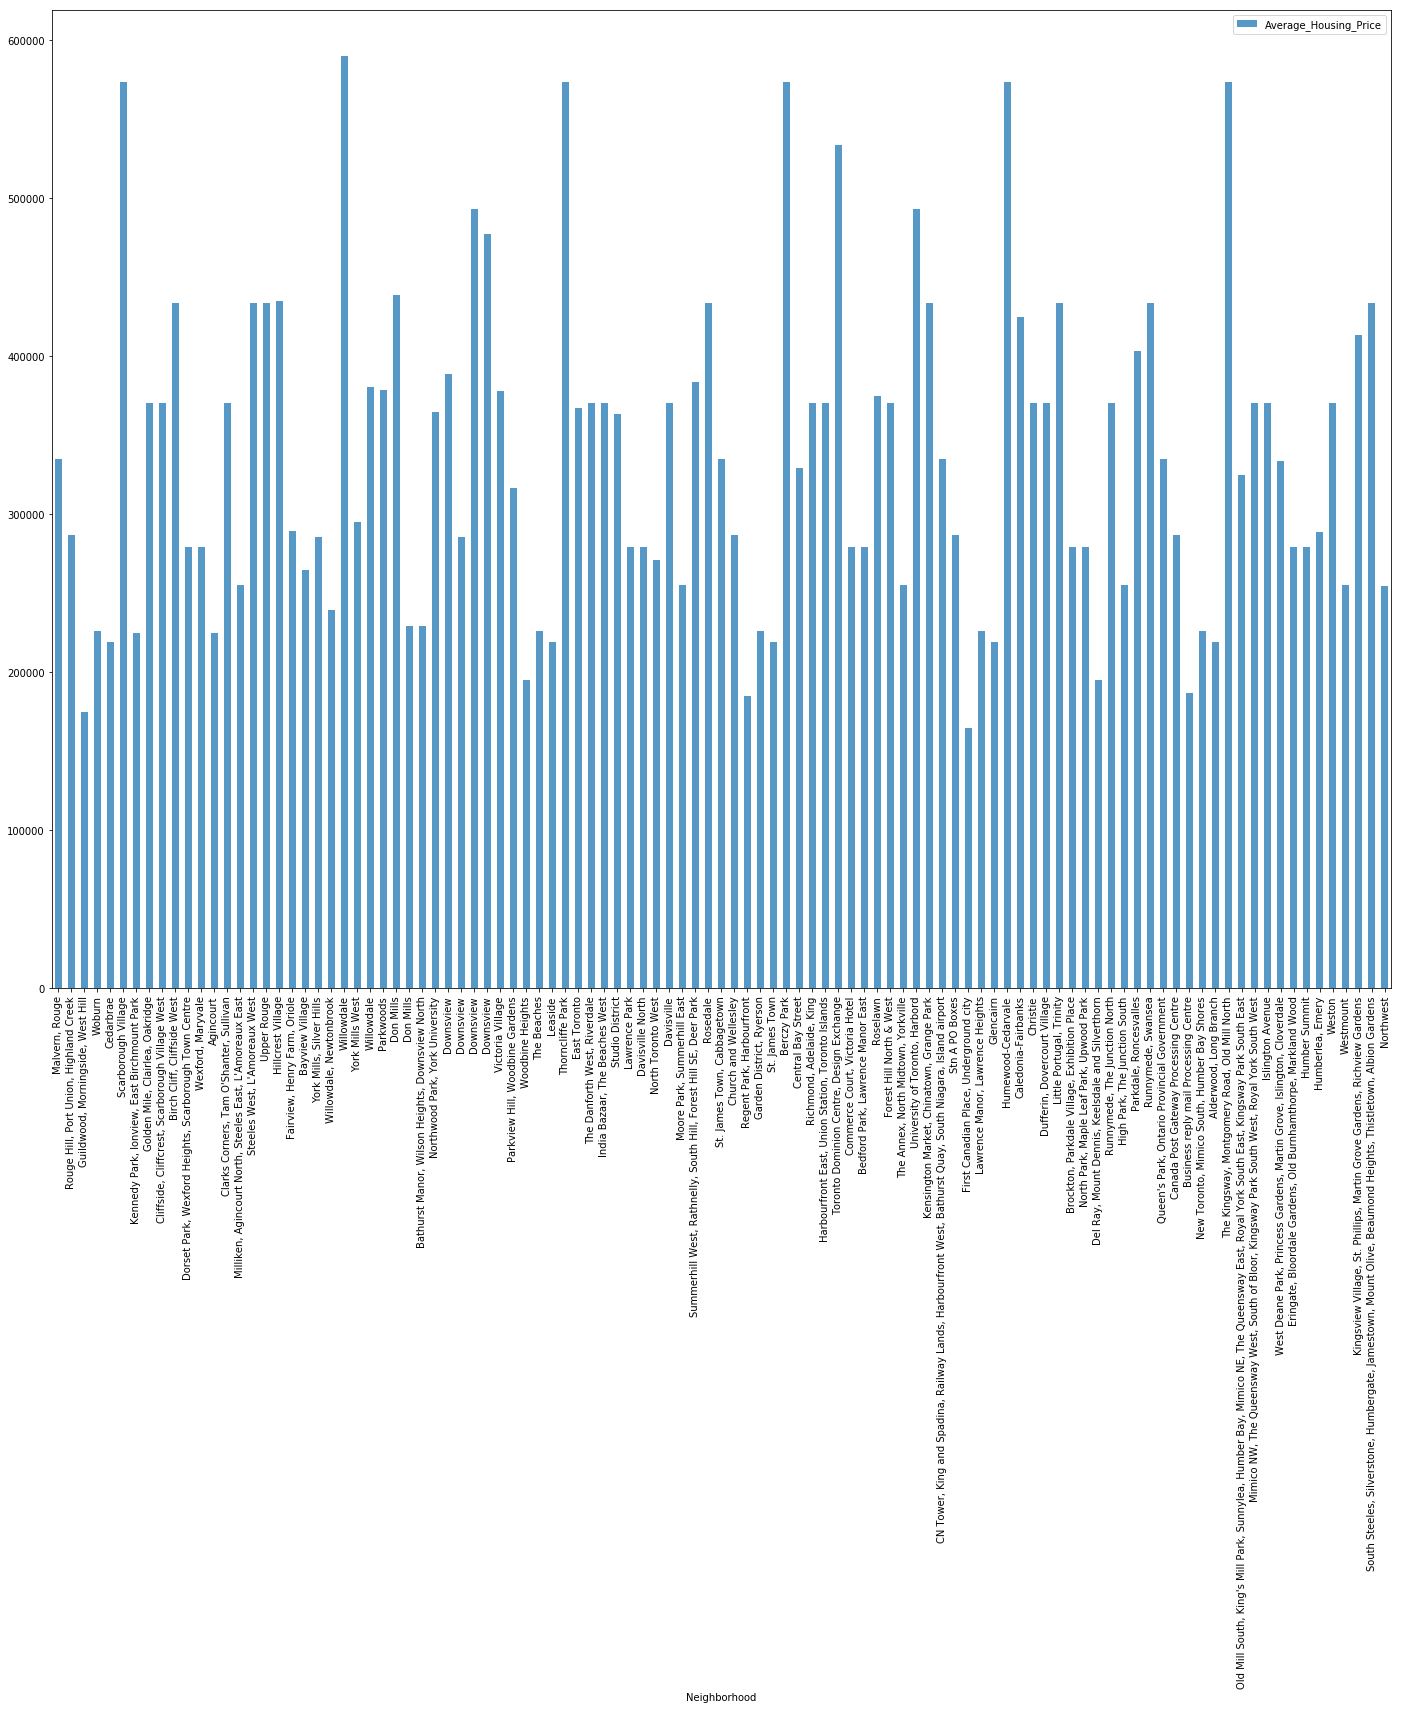

In [55]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

### School Rating by Clusters

In [56]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [57]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [58]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

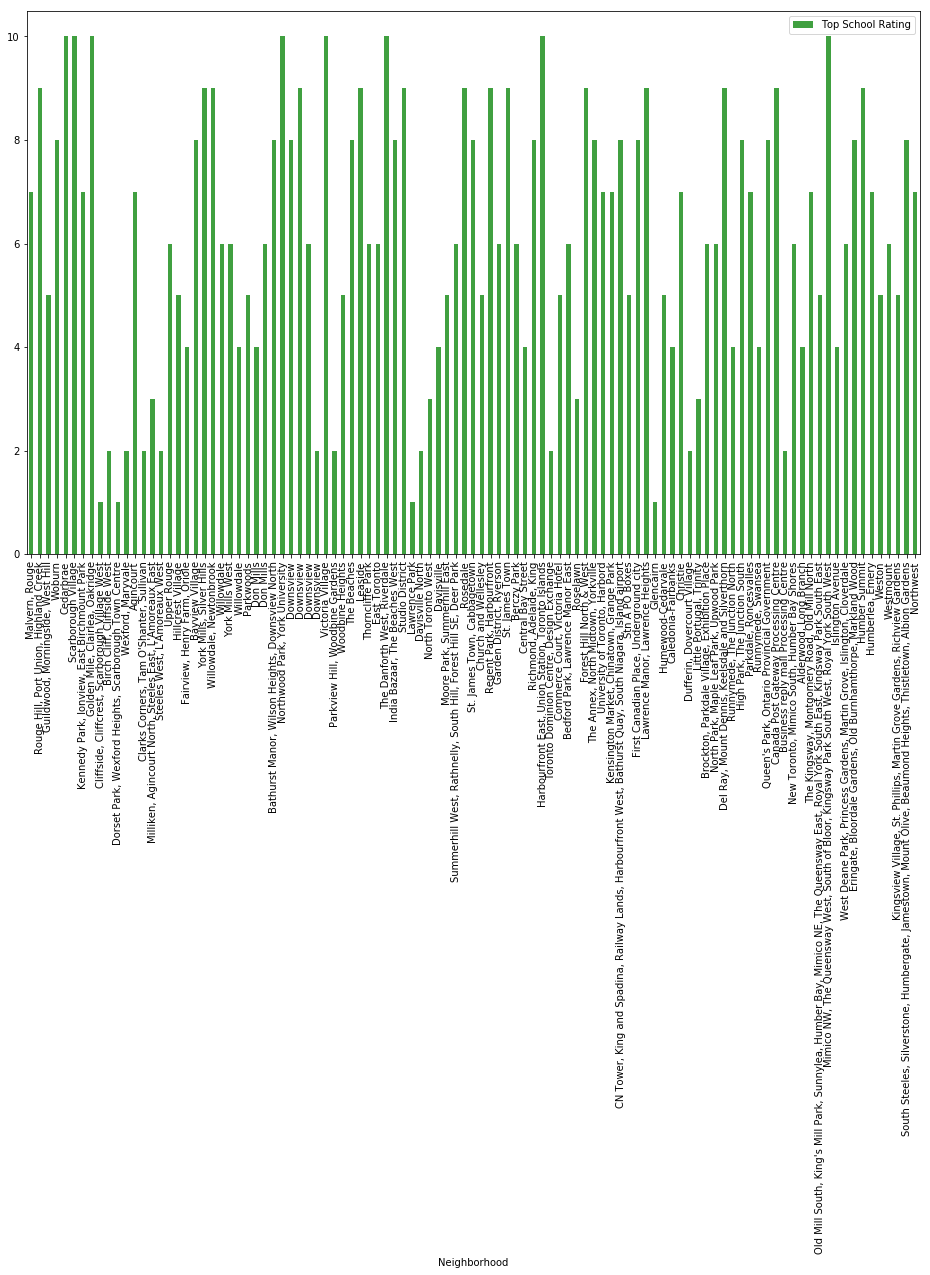

In [59]:
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

### Conclusion: 
In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.